In [2]:
import time
import numpy as np
import copy
import pandas as pd
import torch
from torch import cuda
import torchvision
from torchvision import transforms, models, datasets
from PIL import Image
import os
from os import listdir,makedirs

# Preparing the data

In [3]:
images_dir = "/nbs/course-v3/alex/final_data/"
train_dir = images_dir + "train"
validation_dir = images_dir + "val"
test_dir = images_dir + "test"

dirs = {"train": train_dir,
        "validation": validation_dir,
        "test": test_dir}

Calculating the mean and std of the training set

In [4]:
size = (480, 480)
transforms_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size),
    transforms.CenterCrop(448),
    transforms.ToTensor()
])

images_train = datasets.ImageFolder(root=train_dir, transform = transforms_train)
loader_train = torch.utils.data.DataLoader(images_train, batch_size=64, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0.
for data in loader_train:
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print(mean)
print(std)

tensor([0.5060])
tensor([0.2005])


Let's define data transforms on training and test sets

In [5]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness = 0.03),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5060], std = [0.2005])
    ]),
    'validation': transforms.Compose([
        transforms.Grayscale() ,
        transforms.Resize((480, 480)),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5060], std = [0.2005])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale() ,
        transforms.Resize((480, 480)),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5060], std = [0.2005])
    ])
}

Transforming images in the training set to grayscale before feeding them to the network. We do this to reduce training time

In [6]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path, images_class: int, folder, transform):
        self.files = [file for file in listdir(path + folder)]
        self.images = [Image.open(path + folder + file).convert('L').resize((480, 480)) for file in self.files]
        self.images_class: int = images_class
        self.transform = transform

    def __getitem__(self, index):
        return self.transform(self.images[index]), self.images_class
    
    def __len__(self):
        return len(self.files)
    
    def targets(self):
        return [self.__getitem__(i)[1] for i in range(self.__len__())]

dataset_train = (ImageDataset(train_dir, 0, '/BACTERIA/', data_transforms['train'])
                 + ImageDataset(train_dir, 1, '/NORMAL/', data_transforms['train'])
                 + ImageDataset(train_dir, 2, '/VIRUS/', data_transforms['train']))

Load the datasets with ImageFolder

In [7]:
dataset_validation = datasets.ImageFolder(validation_dir, transform = data_transforms['validation'])
dataset_test = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

Now we need to create a weighted sampler which will ensure that each epoch sees a proportional number of all classes. Since our classes are imbalanced, this would mean that we will undersample the larger class

In [8]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
        self.indices = list(range(len(dataset)))
        self.num_samples = len(self.indices)
        # count the occurence of each label
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
    
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)
  
  
    def _get_label(self, dataset, idx):
        return dataset[idx][1]
  
  
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

  
    def __len__(self):
        return self.num_samples

Load the data into batches

In [38]:
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle=False,
                                              sampler=ImbalancedDatasetSampler(dataset_train), drop_last=False,
                                               num_workers = 8)

dataloader_validation = torch.utils.data.DataLoader(dataset_validation, batch_size = batch_size, shuffle=True,
                                                    drop_last=False, num_workers = 8)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle=False,
                                              drop_last=False, num_workers = 8)


Let's visualize how class distribution in a single batch of training/validation/test set can look like:

In [10]:
def class_distribution_in_batch(dl):
    images, labels = next(iter(dl))
    _, counts = np.unique(labels, return_counts=True)
    class_1 = counts[0]
    class_2 = counts[1]
    class_3 = counts[2]
    batch_data = pd.DataFrame({"class 1" : class_1, "class 2": class_2, "class 3": class_3}, index=['number of images'])
    return batch_data
    
class_distribution_in_batch(dataloader_train)

,class 1,class 2,class 3
number of images,15,26,23


We can also visualize the total distribution of classes in training/test set: 

In [11]:
def class_distribution(dl):
    class_1 = 0
    class_2 = 0
    class_3 = 0
    it = 0
    for images, labels in dl:
        _, counts = np.unique(labels, return_counts=True)
        class_1 += counts[0]
        class_2 += counts[1]
        class_3 += counts[2]
        it += 1
    print(it)
    data = pd.DataFrame({"class 1" : class_1, "class 2": class_2, "class 3": class_3}, index=['number of images'])
    return data

class_distribution(dataloader_train)

79


,class 1,class 2,class 3
number of images,1674,1711,1621


Let's visualize a few training images to understand the data augmentations

torch.Size([3, 3602, 3602])
torch.Size([64])


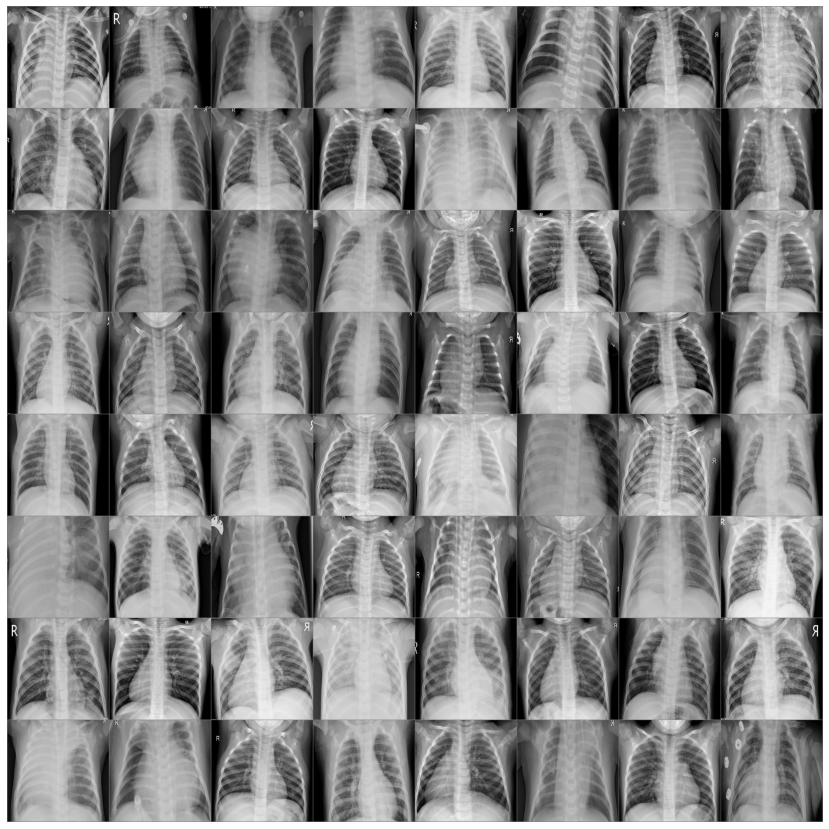

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(image):
    if isinstance(image, torch.Tensor):
        print(image.shape)
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
        print(image.shape)
    # Unnormalize
    mean = np.array([0.5060])
    std = np.array([0.2005])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize = (15, 15))
    plt.imshow(image)
    ax.axis('off')

images, labels = next(iter(dataloader_train))
out = torchvision.utils.make_grid(images, nrow = 8)
imshow(out)
print(labels.data.shape)

# Network class


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
            
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        

        self.fc1 = nn.Linear(in_features=26*26*64, out_features=128)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc1_bn = nn.BatchNorm1d(128)
    
        self.out = nn.Linear(in_features=128, out_features=3)

    def forward(self, t):
        t = self.pool(F.relu(self.conv1(t)))
        t = self.pool(F.relu(self.conv2(t)))        
        t = self.pool(F.relu(self.conv3(t)))
        t = self.pool(F.relu(self.conv4(t))) 
        
        t = t.view(t.size(0), -1)
        t = F.relu(self.fc1(t))
        t = self.dropout(t)
        t = self.fc1_bn(t)
        
        t = self.out(t)
        
        return t

# Training process
1.   Get batch from the training set
2.   Pass the batch to the network
3.   Calculate the loss
4.   Calculate the gradient of the loss function with respect to the network's weights
5.   Update the weights using the gradients to reduce the loss
6.   Repeat steps 1-5 until one epoch is completed
7.   Repeat steps 1-6 for as many epochs required to obtain the desired level of accuracy

Enabling GPU

In [14]:
network = Network()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    network.cuda()

In [14]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(network.parameters())
dataloaders = {'train': dataloader_train, 'validation': dataloader_validation}
file_name = "/nbs/course-v3/alex/sampler_augmentation_448.pt"

def train_model(model, optimizer, dataloaders, file_name,
               max_epochs_stop, num_epochs):
    
    # Early stopping initialization
    validation_loss_min = 0
    validation_best_acc = 0
    
    history = []
    overall_start = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
    
        start = time.time()
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                # Set the model to training mode
                network.train() 
            else:
                # Set model to evaluation mode
                network.eval() 
        
            running_loss = 0
            running_correct = 0
            images_total = 0
               
            for batch in dataloaders[phase]:
                # Unpack the batch into images tensor and labels tensor
                images, labels = batch
                
                # Move tensors to GPU
                if use_cuda and torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
            
                # Telling the optimizer to zero out the gradients that are being held in the grad attribute of the weights
                # We need to do this because PyTorch accumulates gradients
                optimizer.zero_grad()
            
                # Track history only during the training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = network(images) # Pass batch
                    _, preds = torch.max(outputs, 1)
                
                    # Compute loss
                    # cross_entropy combines log softmax and negative log-likelhood loss 
                    loss = F.cross_entropy(outputs, labels)
                
                    if phase == 'train':
                        # Compute gradients
                        loss.backward()
                        # Update weights
                        optimizer.step()
            
            
                # Since the batch size can vary, we adjust the loss calculation to account for batches of different sizes.
                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(preds == labels.data)
                images_total += images.size(0)
        
        
            loss = running_loss/images_total
            acc = running_correct.double()/images_total
            
            history.append([loss, acc])
   
            # Save the model if validation accuracy increases
            if phase == 'validation':
                if acc > validation_best_acc:
                    validation_loss_min = loss
                    validation_best_acc = acc
                    best_epoch = epoch + 1
                    torch.save(network.state_dict(), file_name)
                    
            print('{} loss: {:.4f}, {} accuracy: {:.4f} %' .format(phase, loss, phase, acc*100.0))
    
        print('{} seconds elapsed'.format(time.time() - start))
        print()
    
    print('Training complete in {}'. format(time.time() - overall_start))
    print('Best epoch: {} with loss {:.4f} and accuracy {:.4f} %'.format(best_epoch, validation_loss_min, validation_best_acc*100.0))
    return network, history

In [15]:
model, history = train_model(network, optimizer, dataloaders, file_name, 10, 30)

Epoch 1/30
----------
train loss: 0.7334, train accuracy: 66.5202 %
validation loss: 0.5798, validation accuracy: 76.2963 %
22.49488925933838 seconds elapsed

Epoch 2/30
----------
train loss: 0.5853, train accuracy: 73.6916 %
validation loss: 0.4946, validation accuracy: 77.7778 %
22.37158751487732 seconds elapsed

Epoch 3/30
----------
train loss: 0.5505, train accuracy: 75.0300 %
validation loss: 0.4943, validation accuracy: 76.7901 %
22.20635485649109 seconds elapsed

Epoch 4/30
----------
train loss: 0.5056, train accuracy: 77.4471 %
validation loss: 0.4541, validation accuracy: 80.2469 %
22.187774419784546 seconds elapsed

Epoch 5/30
----------
train loss: 0.4949, train accuracy: 77.1075 %
validation loss: 0.4316, validation accuracy: 80.4938 %
22.487138271331787 seconds elapsed

Epoch 6/30
----------
train loss: 0.4692, train accuracy: 78.5657 %
validation loss: 0.4276, validation accuracy: 84.4444 %
22.397855281829834 seconds elapsed

Epoch 7/30
----------
train loss: 0.4458, t

# Visualizing results

In [21]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []

for i in range(0, len(history) - 1, 2):
    train_loss.append(history[i][0])
    train_acc.append(history[i][1]*100)

for i in range(1, len(history), 2):
    val_loss.append(history[i][0])
    val_acc.append(history[i][1]*100)

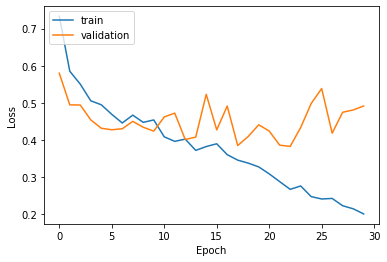

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss.png', bbox_inches='tight')
plt.show()

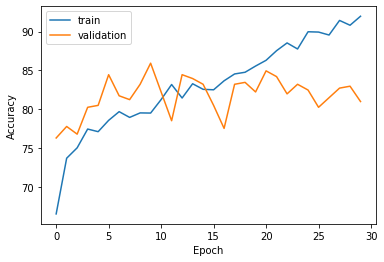

In [23]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc.png', bbox_inches='tight')
plt.show()

# Testing

In [68]:
def test_accuracy(model, file_name):
    model.load_state_dict(torch.load(file_name))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = torch.tensor([]).cuda()
        all_labels = []
    
        for images, labels in dataloader_test:
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # number of samples in current batch
            total += images.size(0)
            correct += torch.sum(preds == labels.data)
            all_preds = torch.cat((all_preds, outputs), dim = 0)
            all_labels += labels.tolist()

        accuracy = 100.0 * correct.double()/total
        print("Total correct: {}, accuracy {:.4f}".format(correct, accuracy))
    return all_preds, torch.tensor(all_labels).cuda()
        
test_preds, test_labels = test_accuracy(network, "/nbs/course-v3/alex/sampler_augmentation_448.pt")

Total correct: 308, accuracy 69.2135


In [85]:
dataloader_test.dataset.samples[239]

('/nbs/course-v3/alex/final_data/test/NORMAL/NORMAL2-IM-0319-0001.jpeg', 1)

In [20]:
from torchsummary import summary
summary(model, input_size=(1, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 446, 446]             320
         MaxPool2d-2         [-1, 32, 223, 223]               0
            Conv2d-3         [-1, 64, 221, 221]          18,496
         MaxPool2d-4         [-1, 64, 110, 110]               0
            Conv2d-5         [-1, 64, 108, 108]          36,928
         MaxPool2d-6           [-1, 64, 54, 54]               0
            Conv2d-7           [-1, 64, 52, 52]          36,928
         MaxPool2d-8           [-1, 64, 26, 26]               0
            Linear-9                  [-1, 128]       5,537,920
          Dropout-10                  [-1, 128]               0
      BatchNorm1d-11                  [-1, 128]             256
           Linear-12                    [-1, 3]             387
Total params: 5,631,235
Trainable params: 5,631,235
Non-trainable params: 0
---------------------------

# Confusion matrix

In [77]:
stacked = torch.stack((test_labels, test_preds.argmax(dim=1)), dim = 1)
stacked[239]

tensor([1, 0], device='cuda:0')

In [72]:
confusion_matrix = torch.zeros(3,3, dtype=torch.int64)
confusion_matrix

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [73]:
for pair in stacked:
    label, pred = pair.tolist()
    confusion_matrix[label, pred] = confusion_matrix[label, pred] + 1

confusion_matrix

tensor([[122,   1,  26],
        [ 16,  57,  75],
        [ 15,   4, 129]])

In [85]:
dataset_test.classes

['BACTERIA', 'NORMAL', 'VIRUS']

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels.cpu(), test_preds.argmax(dim=1).cpu())
cm

array([[122,   1,  26],
       [ 16,  57,  75],
       [ 15,   4, 129]])

In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylim(3-0.5, -0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_val.png', bbox_inches='tight')

Confusion matrix, without normalization
[[122   1  26]
 [ 16  57  75]
 [ 15   4 129]]


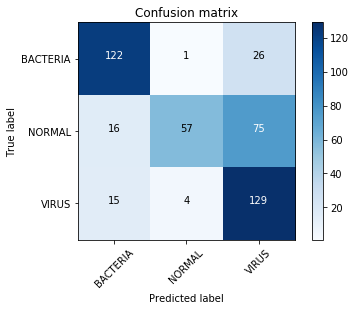

In [127]:
plot_confusion_matrix(cm, dataset_test.classes)

# Confusion matrix on validation set

In [16]:
def validation_accuracy(model, file_name):
    model.load_state_dict(torch.load(file_name))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = torch.tensor([]).cuda()
        all_labels = []
    
        for images, labels in dataloader_validation:
            images = images.cuda()
            labels = labels.cuda()
        
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            # number of samples in current batch
            total += images.size(0)
            correct += torch.sum(preds == labels.data)
            all_preds = torch.cat((all_preds, outputs), dim = 0)
            all_labels += labels.tolist()

        accuracy = 100.0 * correct.double()/total
        print("Total correct: {}, accuracy {:.4f}".format(correct, accuracy))
    return all_preds, torch.tensor(all_labels).cuda()
        
validation_preds, validation_labels = validation_accuracy(network, )

Total correct: 348, accuracy 85.9259


In [17]:
stacked_val = torch.stack((validation_labels, validation_preds.argmax(dim=1)), dim = 1)

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_val = confusion_matrix(validation_labels.cpu(), validation_preds.argmax(dim=1).cpu())
cm_val

array([[114,   2,  21],
       [  1, 130,   3],
       [ 28,   2, 104]])

Confusion matrix, without normalization
[[114   2  21]
 [  1 130   3]
 [ 28   2 104]]


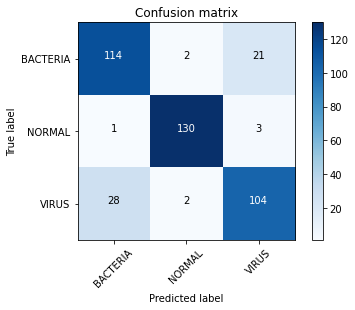

In [24]:
plot_confusion_matrix(cm_val, dataset_validation.classes)